# GD(Gradient Descent)와 SGD(Stochastic Gradient Descent)
GD는 전체 데이터를 이용해 변화도를 계산하고, SGD나 미니배치 GD는 데이터의 서브셋을 이용해 변화도를 계산

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import plotly.graph_objects as go

### Data Creation
$y = 3x^2 + 10x -2$

In [2]:
x = np.random.uniform(-5, 3, 100)

a = np.random.normal(3, 0.5, len(x))
b = np.random.normal(10, 1, len(x))
c = np.random.normal(-2, 2, len(x))

y = a*x**2 + b*x + c

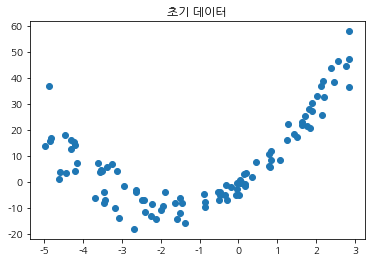

In [3]:
plt.scatter(x, y)
plt.title("초기 데이터")
plt.show()

### 매개변수 공간 시각화
3차원 공간에서 매개변수를 시각화

In [4]:
a_pred = np.arange(2.5, 3.5, 0.025)
b_pred = np.arange(9, 11, 0.05)
c_pred = -2

In [5]:
errors = np.zeros((len(a_pred), len(b_pred)))
errors.shape

(40, 40)

`error`를 `a`와 `b`의 MSE로 계산하고 저장함

In [6]:
for i in range(a_pred.shape[0]):
    for j in range(b_pred.shape[0]):
        y_pred = a_pred[i]*x**2 + b_pred[j]*x + c_pred
        error = y - y_pred
        mse = np.mean(error**2)
        errors[i][j] = mse

In [7]:
fig = go.Figure(data = [go.Surface(z=errors, x=a_pred, y=b_pred)])
fig.update_layout(title = "Parameter Space", width = 640, height = 640,
                  margin = dict(l=65, r=50, b=65, t=90))
fig.show()

각각 25개의 미니배치로 만든 서브셋에 대한 각각의 파라미터 스페이스를 만들 수도 있음  
서로 다른 데이터 샘플이 오류를 계산하는 데 사용되기 때문에 각 매개 변수 공간은 다르게 보임  
미니 배치에 내재된 이러한 의도적인 **노이즈** 는 모델이 테스트 데이터를 보다 견고하고 일반화할 수 있게 만드는 것임

In [8]:
minibatch_errors = np.zeros((4, len(a_pred), len(b_pred)))

for k in range(4):
  for i in range(a_pred.shape[0]):
    for j in range(b_pred.shape[0]):
      batch_x = x[k*25:(k+1)*25]
      batch_y = y[k*25:(k+1)*25]
      y_pred = a_pred[i]*batch_x**2 + b_pred[j]*batch_x + c_pred
      error = batch_y - y_pred
      mse = np.mean(error ** 2)
      minibatch_errors[k][i][j] = mse

In [9]:
fig = go.Figure(data = [go.Surface(z=minibatch_errors[0], x=a_pred, y=b_pred),
                        go.Surface(z=minibatch_errors[1], x=a_pred, y=b_pred, showscale = False, opacity = 0.5),
                        go.Surface(z=minibatch_errors[2], x=a_pred, y=b_pred, showscale = False, opacity = 0.5),
                        go.Surface(z=minibatch_errors[3], x=a_pred, y=b_pred, showscale = False, opacity = 0.5)])
fig.update_layout(title = "Parameter Space", width = 640, height = 640,
                  margin = dict(l=65, r=50, b=65, t=90))
fig.show()

### 훈련 과정 시각화
- GD
- SGD
  - with no randomized mini-batch
  - with randomized mini-batch

랜덤화되지 않은 미니 배치란 모든 에폭에 대해 동일한 순서로 교육 데이터를 얻는 것을 의미

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [11]:
# 모델 정의
class Quadratic(nn.Module):
  def __init__(self):
    super(Quadratic, self).__init__()
    self.W = nn.Linear(in_features=2, 
                       out_features=1, 
                       bias=True)

  def forward(self, x):
    x2 = x ** 2
    xs = torch.cat([x, x2], dim = 1)
    out = self.W(xs)
    return out

In [12]:
Q = Quadratic()

train_x = torch.Tensor(x).view(-1, 1)
train_y = torch.Tensor(y).view(-1, 1)

##### Tensor 차원 변환
- `view`
- `reshape`

contiguous(인접한) 속성을 만족하지 않는 텐서에 적용이 가능하냐의 여부 -> `reshape`는 적용 가능하지만, `view`는 적용 불가능함

#### Gradient Descent(경사 하강법)

In [13]:
from torch.optim import SGD

In [14]:
epochs = 300
lr = 1e-3

loss = nn.MSELoss()
optm = torch.optim.SGD(Q.parameters(), lr=lr)

loss_GD, params_GD = [], []

for epoch in range(epochs):
    y_pred = Q.forward(train_x)
    loss_out = loss(y_pred, train_y)
    
    optm.zero_grad()
    loss_out.backward()
    optm.step()
    
    loss_GD.append(loss_out.item())
    model_param = list(Q.W.parameters())
    params_GD.append([model_param[0][0][0].item(), model_param[0][0][1].item(), model_param[1][0].item()])

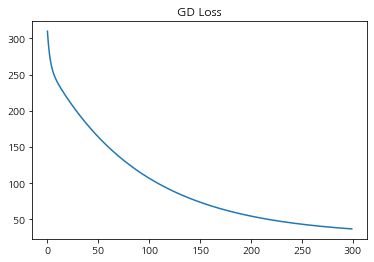

In [15]:
plt.plot(loss_GD)
plt.title("GD Loss")
plt.show()

In [16]:
b_hat, a_hat, c_hat = params_GD[-1]
print(b_hat, a_hat, c_hat)

7.706145286560059 2.2722396850585938 0.7307480573654175


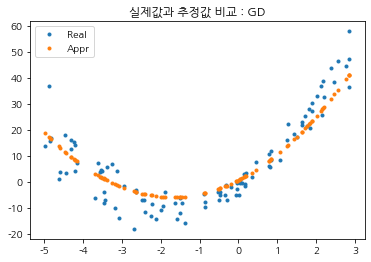

In [17]:
plt.plot(x, a*x**2 + b*x + c, ".")
plt.plot(x, a_hat*x**2 + b_hat*x + c_hat, ".")
plt.title("실제값과 추정값 비교 : GD")
plt.legend(["Real", "Appr"])
plt.show()

In [18]:
params_GD = np.array(params_GD)
params_GD.shape

(300, 3)

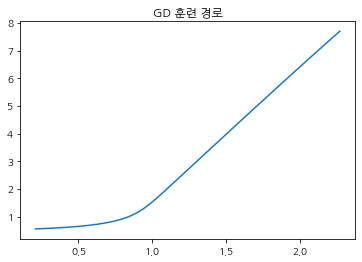

In [19]:
plt.plot(params_GD[:, 1], params_GD[:, 0])
plt.title("GD 훈련 경로")
plt.show()

#### SGD w/o randomization
미니 배치를 위해 `DataLoader`를 사용

In [20]:
from torch.utils.data import DataLoader, TensorDataset

data_set = TensorDataset(train_x, train_y)
data_loader = DataLoader(data_set, batch_size=25, shuffle=False)

In [21]:
Q2 = Quadratic()

In [22]:
loss = nn.MSELoss()
optm = torch.optim.SGD(Q2.parameters(), lr=lr)

loss_SGDr = []
params_SGDr = []
for epoch in range(epochs):
  for batch_x, batch_y in data_loader:
    y_pred = Q2.forward(batch_x)
    loss_out = loss(y_pred, batch_y)

    optm.zero_grad()
    loss_out.backward()
    optm.step()

    loss_SGDr.append(loss_out.item())
    model_param = list(Q2.W.parameters())
    params_SGDr.append([model_param[0][0][0].item(), model_param[0][0][1].item(), model_param[1][0].item()])

In [23]:
b_hat, a_hat, c_hat = params_SGDr[-1]
print(b_hat, a_hat, c_hat)

9.647672653198242 2.7436347007751465 -0.5166407227516174


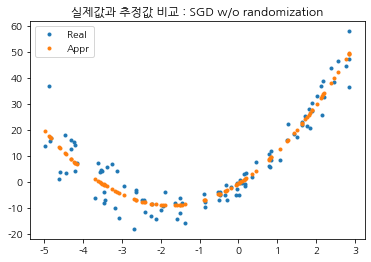

In [24]:
plt.plot(x, a*x**2 + b*x + c, ".")
plt.plot(x, a_hat*x**2 + b_hat*x + c_hat, ".")
plt.title("실제값과 추정값 비교 : SGD w/o randomization")
plt.legend(["Real", "Appr"])
plt.show()

In [26]:
params_SGDr = np.array(params_SGDr)
params_SGDr.shape

(1200, 3)

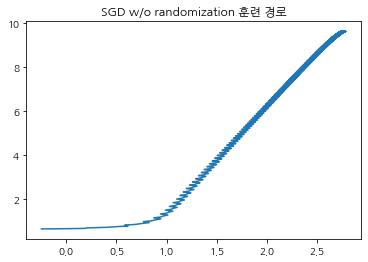

In [28]:
plt.plot(params_SGDr[:, 1], params_SGDr[:, 0])
plt.title("SGD w/o randomization 훈련 경로")
plt.show()

#### SGD w randomization

In [29]:
data_loader = DataLoader(data_set, batch_size = 25, shuffle = True)

In [30]:
Q3 = Quadratic()

In [32]:
loss = nn.MSELoss()
optm = torch.optim.SGD(Q3.parameters(), lr=lr)

loss_SGDwr = []
params_SGDwr = []
for epoch in range(epochs):
  for batch_x, batch_y in data_loader:
    y_pred = Q3.forward(batch_x)
    loss_out = loss(y_pred, batch_y)

    optm.zero_grad()
    loss_out.backward()
    optm.step()

    loss_SGDwr.append(loss_out.item())
    model_param = list(Q3.W.parameters())
    params_SGDwr.append([model_param[0][0][0].item(), model_param[0][0][1].item(), model_param[1][0].item()])

In [34]:
b_hat, a_hat, c_hat = params_SGDwr[-1]
print(b_hat, a_hat, c_hat)

9.583563804626465 2.7483909130096436 -0.19477364420890808


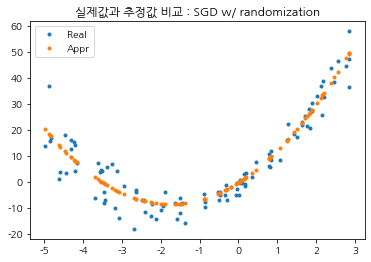

In [35]:
plt.plot(x, a*x**2 + b*x + c, ".")
plt.plot(x, a_hat*x**2 + b_hat*x + c_hat, ".")
plt.title("실제값과 추정값 비교 : SGD w/ randomization")
plt.legend(["Real", "Appr"])
plt.show()

In [36]:
params_SGDwr = np.array(params_SGDr)
params_SGDwr.shape

(1200, 3)

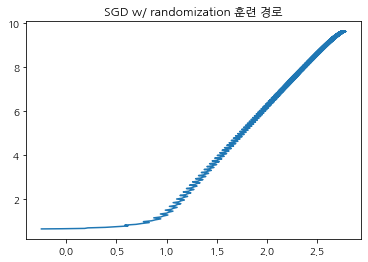

In [37]:
plt.plot(params_SGDr[:, 1], params_SGDr[:, 0])
plt.title("SGD w/ randomization 훈련 경로")
plt.show()

#### GD vs SGD w/o random vs SGD w/ random


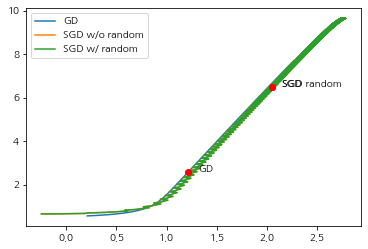

In [38]:
plt.plot(params_GD[:, 1], params_GD[:, 0], label = "GD")
plt.plot(params_SGDr[:, 1], params_SGDr[:, 0], label = "SGD w/o random")
plt.plot(params_SGDwr[:, 1], params_SGDwr[:, 0], label = "SGD w/ random")
plt.plot(params_GD[50, 1], params_GD[50, 0], "ro")
plt.plot(params_SGDr[200, 1], params_SGDr[200, 0], "ro")
plt.plot(params_SGDwr[200, 1], params_SGDwr[200, 0], "ro")
plt.annotate('GD', xy=(params_GD[50, 1]+0.1, params_GD[50, 0]))
plt.annotate('SGD', xy=(params_SGDr[200, 1]+0.1, params_SGDr[200, 0]))
plt.annotate('SGD random', xy=(params_SGDwr[200, 1]+0.1, params_SGDwr[200, 0]))
plt.legend()
plt.show()

빨간 점으로 표시한 부분은 `epoch`가 50인 지점  
-> SGD는 GD보다 훨씬 빠르고, 또한 무작위화를 사용하는 SGD가 SGD보다 약간 빠름

### 훈련 경로 3차원에서 시각화

In [39]:
a_pred = np.arange(-0.5, 3.5, 0.1)
b_pred = np.arange(-1, 11, 0.2)
g_a, g_b = np.meshgrid(a_pred, b_pred)
c_pred = c_hat

In [40]:
errors = np.zeros((len(a_pred), len(b_pred)))
errors.shape

(40, 60)

In [41]:
for i in range(a_pred.shape[0]):
  for j in range(b_pred.shape[0]):
    y_pred = a_pred[i]*x**2 + b_pred[j]*x + c_pred
    error = y-y_pred
    mse = 0.5*np.mean(error**2)
    errors[i][j] = mse

In [42]:
fig = go.Figure(data = [go.Scatter3d(x=params_GD[:, 1], y=params_GD[:, 0], z=loss_GD, 
                                     marker=dict(size=4, color=-np.array(loss_GD), 
                                                 colorscale='bluered', opacity=0.8),
                                     line=dict(color='darkblue', width=2),
                                     name = "GD"),
                        go.Scatter3d(x=params_SGDr[:, 1]+1, y=params_SGDr[:, 0]+1, z=loss_SGDr, 
                                     marker=dict(size=4, color=-np.array(loss_SGDr), 
                                                 colorscale='icefire', opacity=0.8),
                                     line=dict(color='darkred', width=2),
                                     name = "SGD"),
                        go.Scatter3d(x=params_SGDwr[:, 1]+2, y=params_SGDwr[:, 0]+2, z=loss_SGDwr, 
                                     marker=dict(size=4, color=-np.array(loss_SGDwr), 
                                                 colorscale='Viridis', opacity=0.8),
                                     line=dict(color='darkgreen', width=2),
                                     name = "SGD random")])
fig.update_layout(title = "Parameter Space with Paths", width = 640, height = 640,
                  margin = dict(l=65, r=50, b=65, t=90))
fig.show()

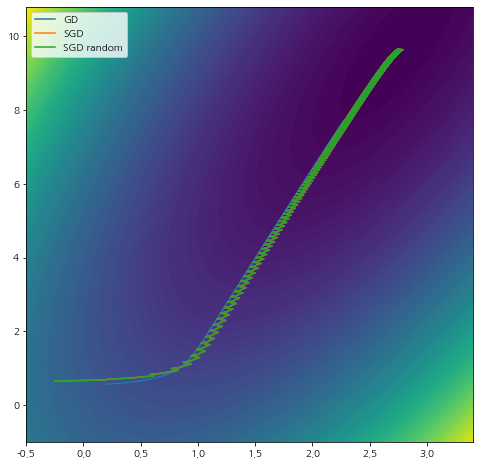

In [43]:
plt.figure(figsize = (8, 8))
plt.contourf(a_pred, b_pred, errors.T, levels = 100)
plt.plot(params_GD[:, 1], params_GD[:, 0], label = "GD")
plt.plot(params_SGDr[:, 1], params_SGDr[:, 0], label = "SGD")
plt.plot(params_SGDwr[:, 1], params_SGDwr[:, 0], label = "SGD random")
plt.legend()
plt.show()